<a href="https://colab.research.google.com/github/jeswinfrancis/FeynnLabsProjects/blob/main/MentalHealthAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install unidecode

In [14]:
import pandas as pd
import numpy as np
import re
from unidecode import unidecode

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import collections

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
df = pd.read_csv('/content/mental_health.csv')

In [7]:
df.head()

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


In [8]:
df['label'].value_counts()

0    14139
1    13838
Name: label, dtype: int64

In [16]:
regex = re.compile('[^a-z\s]')
df['clean_text'] = df['text'].str.lower()
df['clean_text'] = df['clean_text'].apply(lambda x: regex.sub('', x))
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

In [17]:
# Tokenization
df['clean_text'] = df['clean_text'].apply(word_tokenize)

# Removing stopwords
stop_words = set(stopwords.words('english'))
df['clean_text'] = df['clean_text'].apply(lambda x: [word for word in x if word not in stop_words])

# Word normalization
stemmer = SnowballStemmer('english')
df['clean_text'] = df['clean_text'].apply(lambda x: [stemmer.stem(word) for word in x])

# Joining the words back into a single text
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join(x))

Text(0, 0.5, 'Frequency')

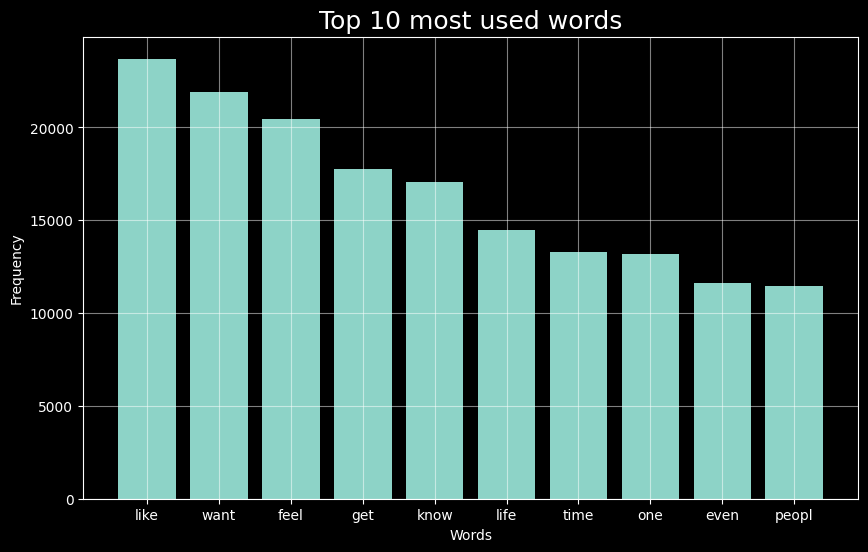

In [21]:
words = []
for text in df['clean_text']:
    words.extend(text.split())
word_count = collections.Counter(words)
top_words = dict(word_count.most_common(10))

# Figure Size and set background
plt.figure(figsize = (10, 6))

# Create the Barplot
plt.bar(range(len(top_words)), list(top_words.values()), align = 'center')

# Creating a y axis with words
plt.xticks(range(len(top_words)), list(top_words.keys()))

# Grid Opacity
plt.grid(alpha = 0.5)
# Title and labels
plt.title('Top 10 most used words', fontsize = 18)
plt.xlabel('Words')
plt.ylabel('Frequency')

In [22]:
# Maximum number of words to be considered in the vocabulary
max_words = 10000
# Maximum number of tokens in a sequence
max_len = 200
# Tokenizer
tokenizer = Tokenizer(num_words = max_words)
# Snap tokenizer to text data
tokenizer.fit_on_texts(df['text'])
# Converts texts into strings of numbers
sequences = tokenizer.texts_to_sequences(df['text'])
# Mapping words to indexes
word_index = tokenizer.word_index

In [23]:
# Sequence padding
data = pad_sequences(sequences, maxlen = max_len)

In [24]:
# Converting labels to numeric format
labels = tf.keras.utils.to_categorical(df['label'])

In [25]:
# Model
model = Sequential()
model.add(Embedding(max_words, 128, input_length = max_len))
model.add(Bidirectional(LSTM(64, dropout = 0.3, recurrent_dropout = 0.2)))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))

# Compile the model
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [26]:
# Checking summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,383,010
Trainable params: 1,383,010
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Fit model
history = model.fit(data, labels, validation_split = 0.2, epochs = 5, batch_size = 32)

Epoch 1/5
700/700 [==============================] - 554s 780ms/step - loss: 0.2641 - accuracy: 0.8933 - val_loss: 0.2150 - val_accuracy: 0.9151
Epoch 2/5
700/700 [==============================] - 546s 780ms/step - loss: 0.1707 - accuracy: 0.9397 - val_loss: 0.2186 - val_accuracy: 0.9128
Epoch 3/5
700/700 [==============================] - 547s 782ms/step - loss: 0.1228 - accuracy: 0.9561 - val_loss: 0.2521 - val_accuracy: 0.9085
Epoch 4/5
700/700 [==============================] - 543s 776ms/step - loss: 0.0976 - accuracy: 0.9652 - val_loss: 0.2906 - val_accuracy: 0.8838
Epoch 5/5
700/700 [==============================] - 543s 776ms/step - loss: 0.0986 - accuracy: 0.9648 - val_loss: 0.2970 - val_accuracy: 0.9107


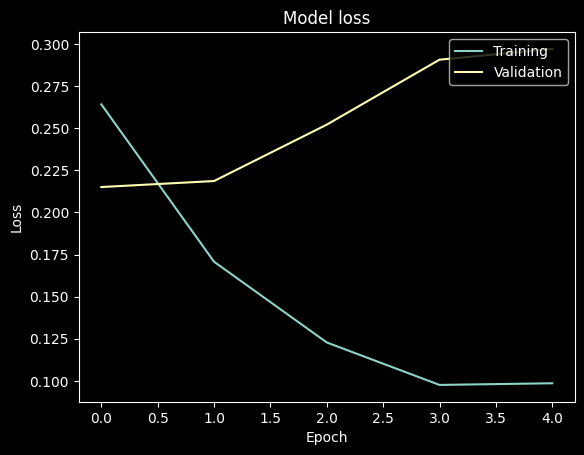

In [29]:
# Loss graph

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc = 'upper right')
plt.show()

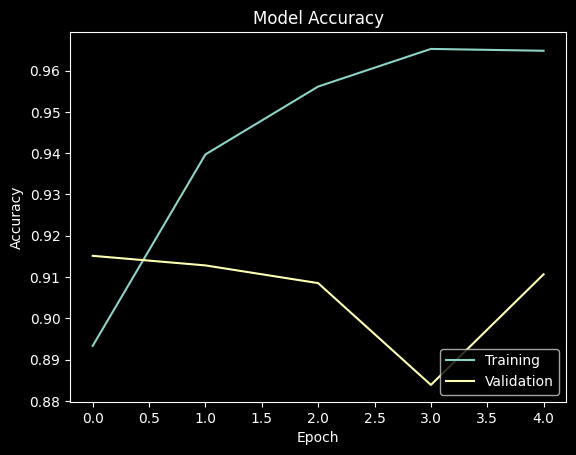

In [30]:
# Accuracy graph
plt.style.use('dark_background')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc = 'lower right')
plt.show()